In [ ]:
%capture
! pip install yellowbrick openai

In [246]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from itertools import islice
from tqdm import tqdm
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from collections import Counter, OrderedDict, defaultdict
import numpy as np
from scipy.special import kl_div
import aiohttp
import asyncio
from aiohttp import ClientSession
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.cluster import DBSCAN

import os
import openai

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme()

In [356]:
df_annotations = pd.read_csv('https://raw.githubusercontent.com/genusB/challenge/master/bot-annotators/nlp-challenge.csv')

## Utils

In [248]:
def flatten_list(nested_list):
  return [item for row in nested_list for item in row]

In [249]:
def get_keys(array_of_dict):
  return [list(d.keys())[0] for d in array_of_dict]

In [250]:
def get_values(array_of_dict):
  return [list(d.values())[0] for d in array_of_dict]

## EDA

In [357]:
df_annotations.head(5)

,Annotator ID,Text,Answer
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True


In [358]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36417 entries, 0 to 36416
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Annotator ID  36417 non-null  object
 1   Text          36417 non-null  object
 2   Answer        36417 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 604.7+ KB


In [359]:
df_annotations.describe()

,Annotator ID,Text,Answer
count,36417,36417,36417
unique,52,12137,2
top,A3MV3PT4TOO69P,@kucoincom Ummmmm Did you guys get hacked? Th...,True
freq,5126,4,19783


In [360]:
df_annotations.isna().sum()

Annotator ID    0
Text            0
Answer          0
dtype: int64

In [361]:
df_annotations.loc[:, 'Text'] = df_annotations['Text'].apply(lambda x: x.strip())

In [362]:
assert len(df_annotations) == len(df_annotations[df_annotations['Text'].str.len() > 0])

In [363]:
unique_id = df_annotations['Annotator ID'].unique()
unique_texts = df_annotations['Text'].unique()

In [364]:
answer_count = df_annotations['Annotator ID'].value_counts().to_dict()

In [365]:
print('Number of annotators:', len(unique_id))
print('Number of unique texts:', len(unique_texts))

Number of annotators: 52
Number of unique texts: 12137


There is no duplicated rows

In [366]:
assert len(df_annotations[df_annotations.groupby(df_annotations.columns.tolist(),as_index=False).size()['size'] > 1]) == 0

For every unique text at least 3 annotators was assigned

In [367]:
df_annotations['Text'].value_counts().value_counts()

3    12131
4        6
Name: Text, dtype: int64

In [368]:
reply_pattern = r'@[^ ]* {0,1}'

replies = df_annotations['Text'].str.findall(reply_pattern)

texts_cleared = df_annotations['Text'].apply(lambda x: re.sub(reply_pattern, '', x))

In [369]:
replies = replies.apply(lambda x: x.strip() if isinstance(x, str) else [r.strip() for r in x])

In [370]:
print('Number of rows without replies:', replies.value_counts()[0])

Number of rows without replies: 7611


In [371]:
unique_replies = len(set(flatten_list(replies.values)))
top_replies = Counter(flatten_list(replies.values))

print('Unique reply accounts:', unique_replies)

Unique reply accounts: 5469


In [372]:
print('Top Replies:\n')

for top_r, count in sorted(top_replies.items(), key=lambda item: (item[1], item[0]), reverse=True)[:10]:
    print(f'{top_r} is appeared {count} times')

Top Replies:

@cz_binance is appeared 9294 times
@binance is appeared 4260 times
@BitMartExchange is appeared 3546 times
@Hotbit_news is appeared 2262 times
@kucoincom is appeared 1792 times
@BitrueOfficial is appeared 1602 times
@JeremyRubin is appeared 1137 times
@etherdelta is appeared 1066 times
@JihanWu is appeared 873 times
@_prestwich is appeared 852 times


In [373]:
top_annotators = Counter(df_annotations['Annotator ID'])
top_annotators = OrderedDict(sorted(top_annotators.items(), key=lambda item: (item[1], item[0]), reverse=True))

print('Top Annotators:\n')

for top_a, count in islice(top_annotators.items(), 10):
    print(f'{top_a} is appeared {count} times')

Top Annotators:

A3MV3PT4TOO69P is appeared 5126 times
A3OCJJMRKAIJZA is appeared 5001 times
A3BISMR4GI02ZG is appeared 3589 times
A1MG8KNVSVZ365 is appeared 3561 times
AQIP3DSYXEXX5 is appeared 3469 times
A2LU259QPV1I4V is appeared 2689 times
A3BJX6UUSOIKFN is appeared 1472 times
A3BCKNE5CWHODZ is appeared 1443 times
A9HQ3E0F2AGVO is appeared 1217 times
ARW1TCHCLEK1W is appeared 1042 times


<Axes: >

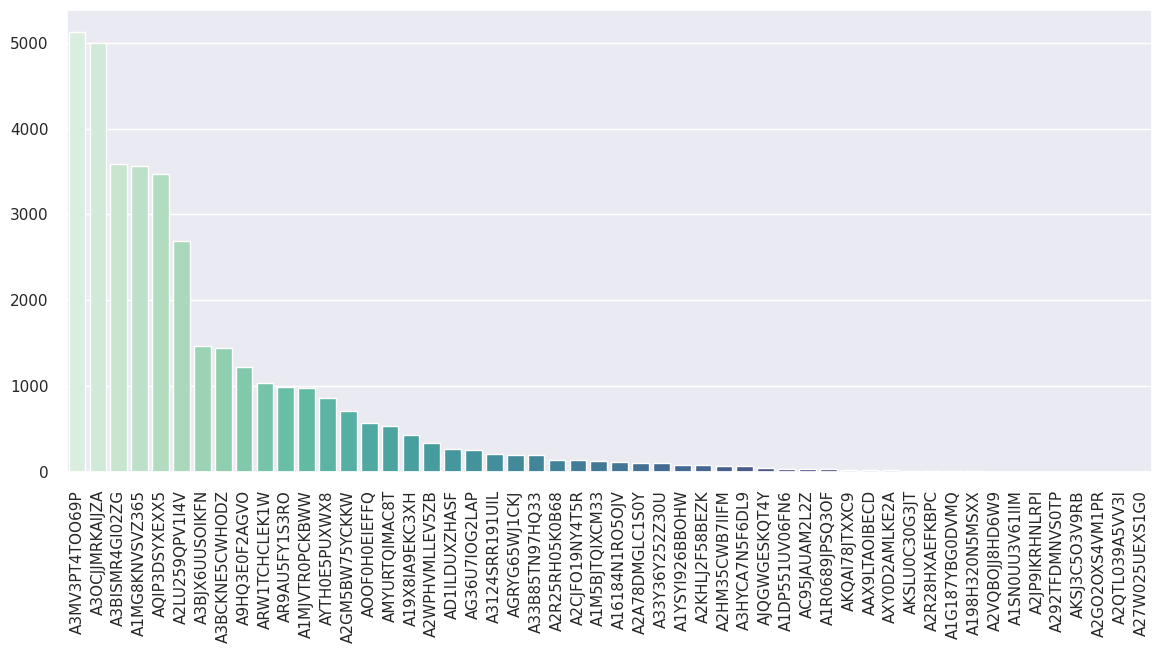

In [374]:
sns.set(rc={'figure.figsize':(14, 6)})
pal = sns.color_palette("mako", len(top_annotators))
plt.xticks(rotation=90)

sns.barplot(x=list(top_annotators.keys()), y=list(top_annotators.values()), palette=np.array(pal[::-1]))

<ipython-input-375-c925d5331af7>:7: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<Axes: ylabel='Count'>

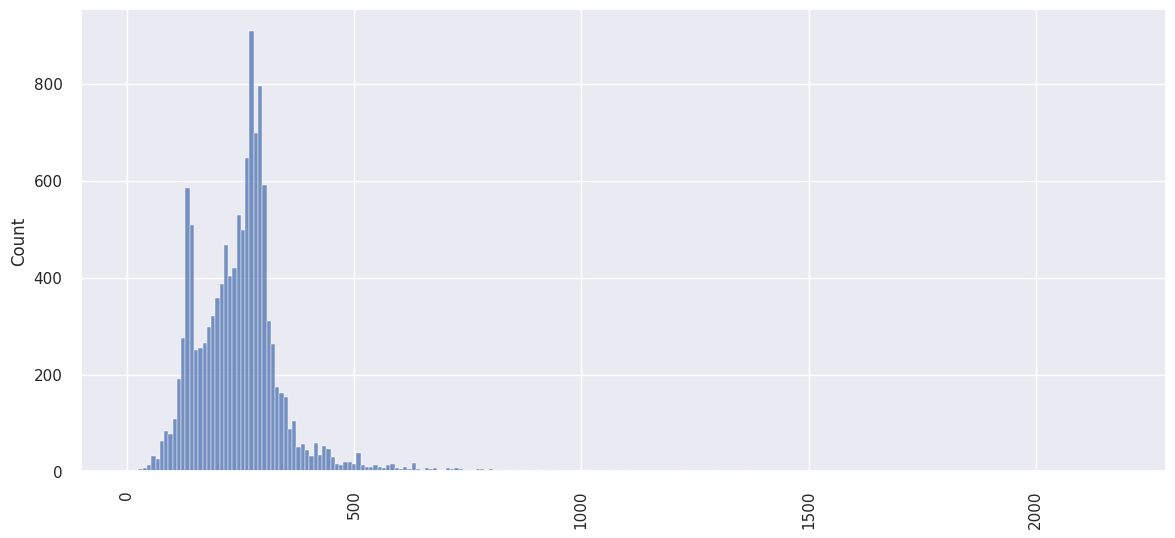

In [375]:
text_lengthes = list(map(lambda x: len(x), unique_texts))

sns.set(rc={'figure.figsize':(14, 6)})
pal = sns.color_palette("mako", len(unique_texts))
plt.xticks(rotation=90)

sns.histplot(data=text_lengthes, palette=np.array(pal[::-1]))

## Bot identifying

### 1. Detect outliers based on success_rate for each annotator

In [376]:
suitable_anns = [ann_id for ann_id in unique_id if answer_count[ann_id] > 40]

In [377]:
df_filtered = df_annotations[df_annotations['Annotator ID'].isin(suitable_anns)]
data_rate = df_filtered.groupby('Annotator ID')['Answer'].mean().reset_index()

In [378]:
X = data_rate['Answer'].to_numpy().reshape(-1, 1)

In [379]:
kern_dens = KernelDensity()
kern_dens.fit(X)

scores = kern_dens.score_samples(X)
scores = -scores
threshold = np.quantile(scores, 0.85)

In [383]:
idx = np.where(scores >= threshold)
suspicious_ids_rate = np.array(data_rate.loc[idx]['Annotator ID'])

In [384]:
suspicious_ids_rate

array(['A19X8IA9EKC3XH', 'A2CJFO19NY4T5R', 'A33Y36Y252Z30U',
       'A3BJX6UUSOIKFN', 'A9HQ3E0F2AGVO'], dtype=object)

### 2. View how often each individual annotator responds differently from the rest of them

In [286]:
ann_count = defaultdict(int)

for text in tqdm(unique_texts):
    res = df_annotations[df_annotations['Text'] == text]
    main_ann = res['Answer'].value_counts().idxmax()
    ann_ids = res[res['Answer'] != main_ann]["Annotator ID"]

    for id in ann_ids:
        ann_count[id] += 1

100%|██████████| 12137/12137 [00:54<00:00, 224.30it/s]


In [287]:
counts = np.array(list(answer_count.values()))

Most likely, bots will be more active than regular annotators. So let's take IDs of annotators from the second half of the distribution

In [288]:
suspicious_ann = dict([(ann_id, ann_count[ann_id] / answer_count[ann_id]) for ann_id in ann_count if answer_count[ann_id] > 40])
suspicious_ann = OrderedDict(sorted(suspicious_ann.items(), key=lambda x:x[1], reverse=True))

In [289]:
np.quantile(list(suspicious_ann.values()), 0.85)

0.28939335511392966

In [350]:
suspicious_ids_difference = np.array([key for key, value in suspicious_ann.items() if value > 0.25])

In [351]:
suspicious_ids_difference

array(['A3BJX6UUSOIKFN', 'A2CJFO19NY4T5R', 'A33Y36Y252Z30U',
       'A9HQ3E0F2AGVO', 'AQIP3DSYXEXX5', 'A3OCJJMRKAIJZA',
       'A1MG8KNVSVZ365'], dtype='<U14')

### 3. Cluster distributions based on KL divergence

In [292]:
df_annotations

,Annotator ID,Text,Answer
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True
...,...,...,...
36412,A3BISMR4GI02ZG,@Hotbit_news @Alex_Hotbit Anyone here knows ho...,False
36413,A3MV3PT4TOO69P,@Hotbit_news @Alex_Hotbit Anyone here knows ho...,False
36414,A3MV3PT4TOO69P,"@etherdelta it's not the case with all dex, #B...",True
36415,A3OCJJMRKAIJZA,"@etherdelta it's not the case with all dex, #B...",True


In [293]:
answer_count = defaultdict(lambda: {'true': 0, 'false': 0})
data = df_filtered.groupby('Annotator ID')['Answer'].value_counts()

for count, (annotator, value) in zip(data, data.index):
  key = 'true' if value else 'false'
  answer_count[annotator][key] = count

In [294]:
distributions = [(ans['true'], ans['false']) for ans in answer_count.values()]

In [295]:
probabilities = [(yes / (yes + no), no / (yes + no)) for yes, no in distributions]

kl_matrix = np.zeros((len(probabilities), len(probabilities)))
for i in range(len(probabilities)):
    for j in range(len(probabilities)):
        p = probabilities[i][0]
        q = probabilities[j][0]

        kl_matrix[i][j] = kl_div(p, q)

kl_matrix[kl_matrix == np.inf] = 1

In [296]:
dbscan=DBSCAN()
dbscan.fit(kl_matrix)

DBSCAN()

In [303]:
annotators_data = df_filtered.groupby('Annotator ID').mean()
annotators_data['dbscan_label'] = dbscan.labels_
annotators_data['dbscan_label'] = annotators_data['dbscan_label'].astype(str)

In [304]:
annotators_data['p'] = [d[0] for d in distributions]
annotators_data['q'] = [d[1] for d in distributions]

In [302]:
px.scatter_3d(data_frame=annotators_data,
              x='p',
              y='q',
              z='Answer',
              color='dbscan_label',
              template='plotly_dark')

In [313]:
suspicious_ids_kl = annotators_data[annotators_data['dbscan_label'] == '-1'].index.to_numpy()

In [314]:
suspicious_ids_kl

array(['A19X8IA9EKC3XH', 'A1MJVTR0PCKBWW', 'A2CJFO19NY4T5R',
       'A33Y36Y252Z30U', 'A3BJX6UUSOIKFN', 'A9HQ3E0F2AGVO',
       'AOOF0H0EIEFFQ'], dtype=object)

### 4. Using external text classification as a ground truth

In [ ]:
text_lengthes = np.array(text_lengthes)
threshold = int(np.quantile(text_lengthes, 0.9))

In [ ]:
idx = np.where(text_lengthes <= threshold)
unique_texts_filtred = unique_texts[idx]

In [ ]:
model_name = "gpt-3.5-turbo"
openai.api_key = ""

max_token_length = 120
system_prompt = "Does this tweet relates to a hacker attack topic, security incident, any vulnerabilities and other similar onces?"

In [ ]:
request_semaphore = asyncio.Semaphore(10)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(2))
async def get_answer(text, model="gpt-3.5-turbo", temperature=1):

    messages = [{
        "role": "system",
        "content": system_prompt
      }, {
        "role": "user",
        "content": text
      }
    ]

    async with request_semaphore:
        response = await openai.ChatCompletion.acreate(
            model = model,
            messages = messages,
            temperature=temperature,
            max_tokens=max_token_length
        )
    return {text: response.choices[0].message["content"]}

In [ ]:
openai.aiosession.set(ClientSession())
results = await asyncio.gather(*[get_answer(text) for text in tqdm(unique_texts_filtred)])
await openai.aiosession.get().close()

100%|██████████| 10925/10925 [00:00<00:00, 330933.96it/s]


In [333]:
no_phrases = ['it does not appear to relate to', 'it does not directly relate to', 'does not relate to', 'it does not mention', 'it does not seem to directly relate', 'does not directly relate to', 'does not specifically mention', 'there is no mention of', 'does not specifically mention', 'does not appear to relate to']

In [334]:
yes_phrases = ['it does mention', 't does suggest', 'phishing attempt', 'scam attempt']

In [335]:
resp_marked = {}

for key, val in zip(get_keys(results), get_values(results)):
  if val.lower().startswith('yes') or any(np in val.lower() for np in yes_phrases):
    resp_marked[key] = True
  elif val.lower().startswith('no') or any(np in val.lower() for np in no_phrases):
    resp_marked[key] = False

In [337]:
from collections import defaultdict

counts = defaultdict(lambda: {'total': 0, 'incorrect': 0})

for _, row in tqdm(df_filtered.iterrows()):
    annotator = row['Annotator ID']
    text = row['Text']
    annotation_result = row['Answer']

    if text in resp_marked:
        counts[annotator]['total'] += 1

        if annotation_result != resp_marked[text]:
            counts[annotator]['incorrect'] += 1

percent_incorrect = {annotator: (data['incorrect'] / data['total']) * 100 for annotator, data in counts.items()}

36205it [00:02, 12288.37it/s]


In [339]:
percent_incorrect = pd.DataFrame({'annotators': percent_incorrect.keys(), 'inc_perc': percent_incorrect.values()})

In [342]:
incorrect_perc = np.array(list(percent_incorrect.inc_perc))
threshold = np.quantile(incorrect_perc, 0.1)

In [347]:
df_filtered = df_annotations[df_annotations['Annotator ID'].isin(suitable_anns)]

idx = np.where(percent_incorrect['inc_perc'] <= threshold)
suspicious_ids_ans = np.array(percent_incorrect.loc[idx].annotators)

### 5. Putting everything together

In [385]:
suspicious_ids_rate

array(['A19X8IA9EKC3XH', 'A2CJFO19NY4T5R', 'A33Y36Y252Z30U',
       'A3BJX6UUSOIKFN', 'A9HQ3E0F2AGVO'], dtype=object)

In [352]:
suspicious_ids_difference

array(['A3BJX6UUSOIKFN', 'A2CJFO19NY4T5R', 'A33Y36Y252Z30U',
       'A9HQ3E0F2AGVO', 'AQIP3DSYXEXX5', 'A3OCJJMRKAIJZA',
       'A1MG8KNVSVZ365'], dtype='<U14')

In [315]:
suspicious_ids_kl

array(['A19X8IA9EKC3XH', 'A1MJVTR0PCKBWW', 'A2CJFO19NY4T5R',
       'A33Y36Y252Z30U', 'A3BJX6UUSOIKFN', 'A9HQ3E0F2AGVO',
       'AOOF0H0EIEFFQ'], dtype=object)

In [349]:
suspicious_ids_ans

array(['A9HQ3E0F2AGVO', 'A2LU259QPV1I4V', 'AJQGWGESKQT4Y',
       'A19X8IA9EKC3XH'], dtype=object)

In [394]:
candidates = np.unique(np.concatenate((suspicious_ids_rate, suspicious_ids_ans, suspicious_ids_difference, suspicious_ids_ans)))

In [448]:
scores = pd.DataFrame({'annotator': candidates, 'score': np.zeros(len(candidates))})

In [449]:
def update_score(row):
  if row.annotator in suspicious_ids_rate:
    row.score += 0.3
  if row.annotator in suspicious_ids_difference:
    row.score += 0.3
  if row.annotator in suspicious_ids_kl:
    row.score += 0.3
  if row.annotator in suspicious_ids_ans:
    row.score += 0.1
  return row

In [450]:
scores = scores.apply(update_score, axis=1)

In [452]:
scores = scores[scores.score >= 0.5]

By combining several assessment methods, assigning a certain weight to each of them, the list of suspicious accounts looks like this

In [464]:
print(*list(scores.annotator), sep='\n')

A19X8IA9EKC3XH
A2CJFO19NY4T5R
A33Y36Y252Z30U
A3BJX6UUSOIKFN
A9HQ3E0F2AGVO
